# Pareto Curve Analysis
This notebook provides a comprehensive function to plot Pareto curves showing the tradeoff between benchmark cost and error rate.

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
from scipy.spatial import ConvexHull
import warnings
warnings.filterwarnings('ignore')

In [70]:
def calculate_pareto_frontier(df, price_col, error_col):
    """
    Calculate the Pareto frontier for a given dataset.
    
    A point is on the Pareto frontier if no other point has both:
    - Lower or equal price AND lower error
    - Lower or equal error AND lower price
    
    Parameters:
        df: DataFrame with price and error data
        price_col: Column name for price (x-axis)
        error_col: Column name for error rate (y-axis)
    
    Returns:
        DataFrame with only Pareto optimal points
    """
    if len(df) == 0:
        return df
    
    # Sort by price (ascending)
    df_sorted = df.sort_values(price_col).copy()
    
    # Initialize Pareto frontier
    pareto_points = []
    min_error = float('inf')
    
    for idx, row in df_sorted.iterrows():
        if row[error_col] < min_error:
            pareto_points.append(idx)
            min_error = row[error_col]
    
    return df.loc[pareto_points].sort_values(price_col)

In [71]:
def plot_pareto_curves(
    df,
    price_col='Benchmark Cost USD',
    benchmark_col='MMLU-Pro (Reasoning & Knowledge)',
    color_by='open_weight',  # 'open_weight', 'moe', or None
    moe_col=None,  # Column name for MoE indicator if available
    show_model_names=False,
    time_periods=None,  # List of (month, year) tuples, e.g., [(6, 2024), (12, 2024)]
    include_current=True,  # Include current data as latest time period
    open_license_only=False,
    figsize=(14, 10),
    title=None,  # Now always available for user override
    save_path=None
):
    """
    Plot Pareto curves showing the tradeoff between benchmark price and error rate.

    Parameters:
        df: DataFrame containing model data
        price_col: Column name for benchmark price (x-axis)
        benchmark_col: Column name for benchmark score (will be converted to error rate)
        color_by: How to color points - 'open_weight', 'moe', or None
        moe_col: Column name for MoE indicator (True/False) if coloring by MoE
        show_model_names: If True, display model names next to Pareto frontier points only
        time_periods: List of (month, year) tuples for Pareto curves at different times
                     e.g., [(6, 2024), (9, 2024), (12, 2024)]
        include_current: If True, include all current data as the latest time period
        open_license_only: If True, only include open-weight models
        figsize: Figure size tuple (width, height)
        title: Custom title for the plot
        save_path: Optional path to save the figure

    Returns:
        fig, ax: matplotlib figure and axes objects
    """

    # === FONT SIZE PARAMETERS ===
    TICK_LABELSIZE = 22
    AXIS_LABELSIZE = 26
    AXIS_LABELWEIGHT = 'bold'
    TITLE_FONTSIZE = 28
    TITLE_FONTWEIGHT = 'bold'
    TITLE_PAD = 24
    LEGEND_FONTSIZE = 20
    ANNOTATE_FONTSIZE = 15

    # ====== POINT SIZE VARIABLES (NOT PARAMETERS!) ======
    # Feel free to change these variables below for point sizing!
    POINT_SIZE_SCATTER = 200   # size for all scatter plot points
    PARETO_POINT_SIZE_LATEST = int(1.2 * POINT_SIZE_SCATTER)
    PARETO_POINT_SIZE_PREV = int(1.0 * POINT_SIZE_SCATTER)

    # Work on a copy
    df_work = df.copy()

    # Parse benchmark scores (handle "XX%" format)
    df_work[benchmark_col] = (
        df_work[benchmark_col].astype(str)
        .str.replace('%', '', regex=False)
        .str.strip()
    )
    df_work[benchmark_col] = pd.to_numeric(df_work[benchmark_col], errors='coerce')

    # Calculate error rate (1 - score/100)
    df_work['error_rate'] = 1 - (df_work[benchmark_col] / 100)

    # Parse prices (handle "$X,XXX" format)
    df_work[price_col] = (
        df_work[price_col].astype(str)
        .str.replace('[$,]', '', regex=True)
    )
    df_work[price_col] = pd.to_numeric(df_work[price_col], errors='coerce')

    # Parse dates
    df_work['Release Date'] = pd.to_datetime(df_work['Release Date'])

    # Filter: open license
    if open_license_only:
        df_work = df_work[
            df_work['License'].notna() &
            df_work['License'].str.contains('open', case=False, na=False)
        ]

    # Determine if open weight (for coloring)
    df_work['is_open_weight'] = (
        df_work['License'].notna() &
        df_work['License'].str.contains('open', case=False, na=False)
    )

    # Drop rows with missing data
    df_work = df_work.dropna(subset=['Release Date', price_col, 'error_rate'])
    df_work = df_work[df_work[price_col] > 0]

    if len(df_work) == 0:
        print("No valid data to plot after filtering")
        return None, None

    # Set up the plot
    fig, ax = plt.subplots(figsize=figsize, dpi=100)
    fig.patch.set_facecolor('white')
    ax.set_facecolor('white')

    # Determine coloring scheme
    if color_by == 'moe' and moe_col is not None and moe_col in df_work.columns:
        color_column = moe_col
        color_label = 'MoE'
        colors_map = {True: '#E74C3C', False: '#3498DB'}
        labels_map = {True: 'MoE', False: 'Dense'}
    elif color_by == 'open_weight':
        color_column = 'is_open_weight'
        color_label = 'License Type'
        colors_map = {True: '#27AE60', False: '#8E44AD'}
        labels_map = {True: 'Open Weight', False: 'Closed Weight'}
    else:
        color_column = None
        color_label = None

    # Prepare time periods
    if time_periods is None:
        time_periods = []

    # Create list of all time periods with their data
    time_period_data = []

    for month, year in time_periods:
        cutoff_date = pd.Timestamp(year=year, month=month, day=1)
        df_period = df_work[df_work['Release Date'] <= cutoff_date].copy()
        if len(df_period) > 0:
            time_period_data.append({
                'label': f"{datetime(year, month, 1).strftime('%b %Y')}",
                'data': df_period,
                'cutoff': cutoff_date
            })

    # Add current data if requested
    if include_current:
        time_period_data.append({
            'label': 'Current',
            'data': df_work.copy(),
            'cutoff': df_work['Release Date'].max()
        })

    # Colors for time periods
    if len(time_period_data) > 1:
        period_colors = sns.color_palette('viridis', n_colors=len(time_period_data))
    else:
        period_colors = ['#2C3E50']

    # Track legend entries to avoid duplicates
    legend_entries_added = set()

    # Plot scatter points (only for the latest period)
    if len(time_period_data) > 0:
        latest_data = time_period_data[-1]['data']

        if color_column:
            # Plot by color groups
            for value, color in colors_map.items():
                df_subset = latest_data[latest_data[color_column] == value]
                if len(df_subset) > 0:
                    ax.scatter(
                        df_subset[price_col],
                        df_subset['error_rate'],
                        c=color,
                        s=POINT_SIZE_SCATTER,
                        alpha=0.6,
                        edgecolors='white',
                        linewidth=1.5,
                        label=labels_map[value],
                        zorder=3
                    )
                    legend_entries_added.add(labels_map[value])
        else:
            # Single color for all points
            ax.scatter(
                latest_data[price_col],
                latest_data['error_rate'],
                c='#2C3E50',
                s=POINT_SIZE_SCATTER,
                alpha=0.6,
                edgecolors='white',
                linewidth=1.5,
                zorder=3
            )

    # Plot Pareto frontiers for each time period
    for i, period_info in enumerate(time_period_data):
        df_period = period_info['data']
        period_label = period_info['label']
        period_color = period_colors[i]
        is_latest = (i == len(time_period_data) - 1)

        # Calculate Pareto frontier
        pareto_df = calculate_pareto_frontier(df_period, price_col, 'error_rate')

        if len(pareto_df) > 0:
            linestyle = '-' if is_latest else '--'
            linewidth = 3 if is_latest else 2

            # If we have color_by set, color markers individually for ALL periods
            if color_column:
                # Plot the line without markers first
                ax.plot(
                    pareto_df[price_col],
                    pareto_df['error_rate'],
                    color=period_color,
                    linestyle=linestyle,
                    linewidth=linewidth,
                    label=f'Pareto Frontier ({period_label})',
                    zorder=5,
                    alpha=0.9
                )

                # Now plot colored markers for each point on the frontier
                for _, row in pareto_df.iterrows():
                    point_color = colors_map.get(row[color_column], period_color)
                    marker_size = PARETO_POINT_SIZE_LATEST if is_latest else PARETO_POINT_SIZE_PREV
                    ax.scatter(
                        [row[price_col]],
                        [row['error_rate']],
                        c=point_color,
                        s=marker_size,
                        marker='o',
                        edgecolors='white',
                        linewidth=2.5,
                        zorder=6,
                        alpha=1.0
                    )
            else:
                # Standard plot with uniform colored markers (when no color_by is set)
                ax.plot(
                    pareto_df[price_col],
                    pareto_df['error_rate'],
                    color=period_color,
                    linestyle=linestyle,
                    linewidth=linewidth,
                    marker='o',
                    markersize=10,
                    markerfacecolor=period_color,
                    markeredgecolor='white',
                    markeredgewidth=2,
                    label=f'Pareto Frontier ({period_label})',
                    zorder=5,
                    alpha=0.9
                )

            # Add model names if requested (only for the latest period Pareto frontier)
            if show_model_names and is_latest:
                for _, row in pareto_df.iterrows():
                    ax.annotate(
                        row['Model'],
                        (row[price_col], row['error_rate']),
                        xytext=(5, 5),
                        textcoords='offset points',
                        fontsize=ANNOTATE_FONTSIZE,
                        alpha=0.8,
                        bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7, edgecolor='gray'),
                        zorder=7
                    )

    # Set log scale for x-axis (price)
    ax.set_xscale('log')

    # Format axes
    from matplotlib.ticker import FuncFormatter, PercentFormatter

    def dollar_formatter(x, pos):
        """Format x-axis values as dollar amounts"""
        if x >= 1:
            return f"${x:.0f}"
        elif x >= 0.01:
            return f"${x:.2f}"
        elif x >= 0.001:
            return f"${x:.3f}"
        else:
            return f"${x:.4f}"

    ax.xaxis.set_major_formatter(FuncFormatter(dollar_formatter))
    ax.yaxis.set_major_formatter(PercentFormatter(1.0))

    # Labels and title
    ax.set_xlabel('Benchmark Cost (USD)', fontsize=AXIS_LABELSIZE, fontweight=AXIS_LABELWEIGHT)
    ax.set_ylabel('Error Rate', fontsize=AXIS_LABELSIZE, fontweight=AXIS_LABELWEIGHT)

    # Title block is now always user-overridable
    if title is None or title == '':
        benchmark_name = benchmark_col.split(' ')[0]
        plot_title = f'Pareto Frontier: Benchmark Cost vs Error Rate\n{benchmark_name}'
        if open_license_only:
            plot_title += ' (Open Weight Only)'
    else:
        plot_title = title

    ax.set_title(plot_title, fontsize=TITLE_FONTSIZE, fontweight=TITLE_FONTWEIGHT, pad=TITLE_PAD)

    # Grid
    ax.grid(True, which='major', linestyle='--', linewidth=0.5, alpha=0.7, zorder=0)
    ax.grid(True, which='minor', linestyle=':', linewidth=0.3, alpha=0.4, zorder=0)

    # Legend
    ax.legend(
        loc='best',
        fontsize=LEGEND_FONTSIZE,
        frameon=True,
        fancybox=True,
        framealpha=0.95,
        edgecolor='gray'
    )

    ax.tick_params(axis='both', which='major', labelsize=TICK_LABELSIZE)

    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_color('gray')
        spine.set_linewidth(0.5)

    plt.tight_layout()

    # Save figure if requested
    if save_path is not None:
        import os
        output_dir = os.path.dirname(save_path)
        if output_dir and not os.path.exists(output_dir):
            os.makedirs(output_dir, exist_ok=True)
            print(f"Created directory: {output_dir}")

        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Figure saved to: {save_path}")

    plt.show()

    return fig, ax

## Load Data

In [72]:
# Load the main dataset
df = pd.read_csv('data/price_reduction_models.csv')
# Add MoE column: True if "Known Active Parameters" is not None, else False
df["MoE"] = df["Known Active Parameters"].notna()
print(f"Loaded {len(df)} models")
print(f"Date range: {pd.to_datetime(df['Release Date']).min()} to {pd.to_datetime(df['Release Date']).max()}")

print(df['MoE'].to_string(index=True))

# Create a new DataFrame that only includes models where License is "Open"
df_open = df[df["License"] == "Open"]
print(f"Loaded {len(df_open)} open models")

Loaded 138 models
Date range: 2024-04-01 00:00:00 to 2025-10-01 00:00:00
0      False
1      False
2      False
3      False
4      False
5      False
6      False
7      False
8      False
9      False
10     False
11     False
12     False
13     False
14     False
15     False
16      True
17      True
18     False
19     False
20     False
21     False
22     False
23     False
24     False
25     False
26     False
27      True
28      True
29     False
30     False
31      True
32     False
33      True
34      True
35     False
36     False
37     False
38     False
39      True
40      True
41      True
42     False
43     False
44     False
45     False
46     False
47     False
48     False
49     False
50      True
51     False
52     False
53     False
54     False
55     False
56     False
57     False
58     False
59     False
60     False
61      True
62      True
63     False
64     False
65     False
66     False
67     False
68     False
69     False
70     False
71  

## Example 1: Basic Pareto Curve with Current Data Only

Figure saved to: figures/pareto_basic.png


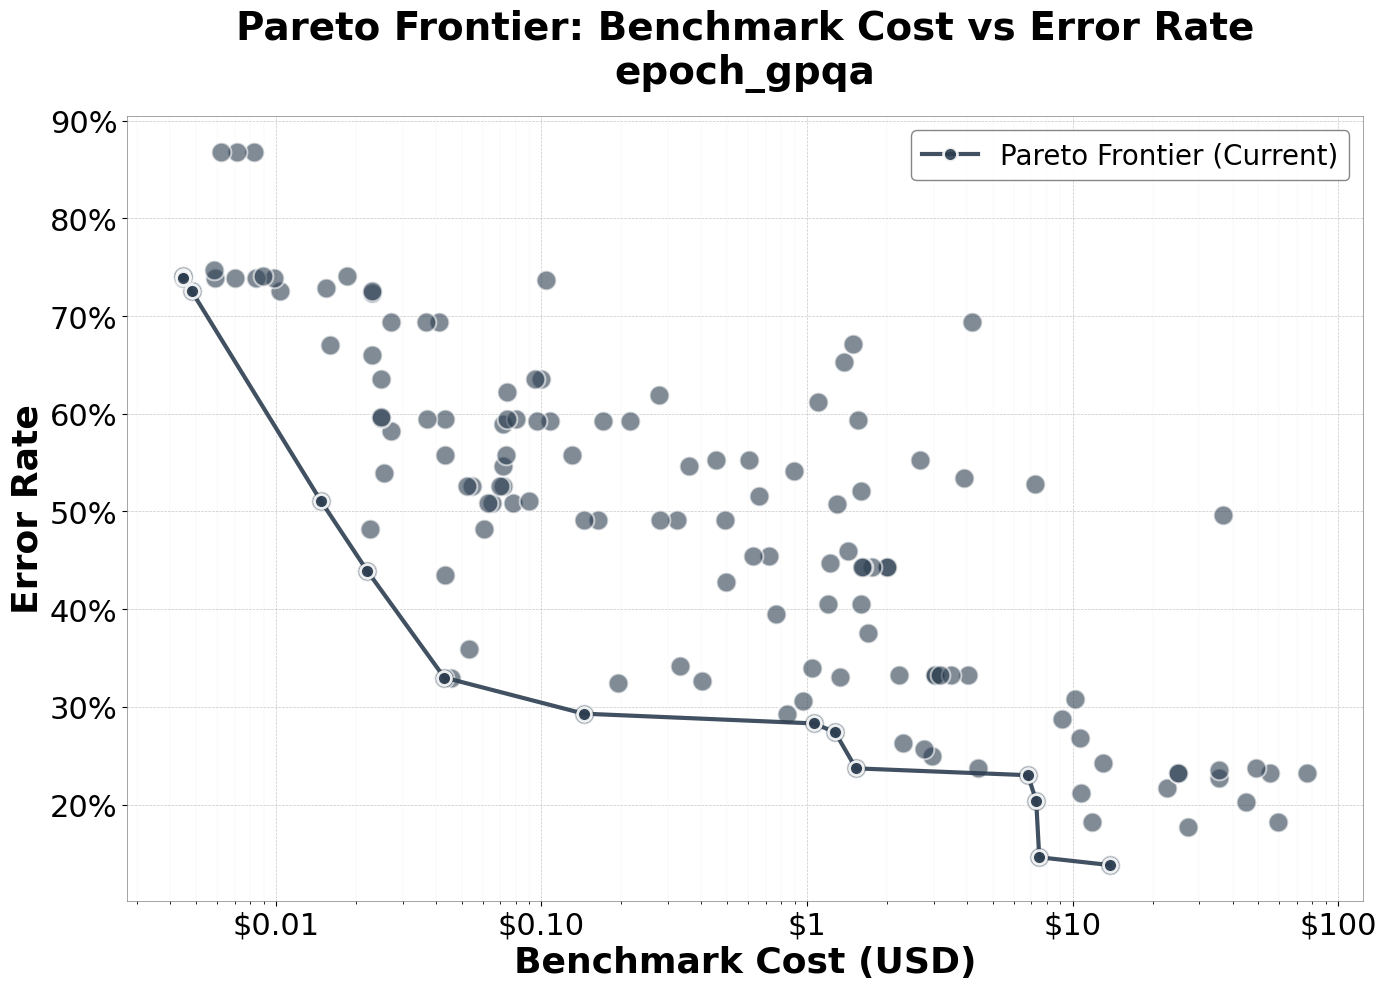

(<Figure size 1400x1000 with 1 Axes>,
 <Axes: title={'center': 'Pareto Frontier: Benchmark Cost vs Error Rate\nepoch_gpqa'}, xlabel='Benchmark Cost (USD)', ylabel='Error Rate'>)

In [73]:
# Simple Pareto curve with current data
plot_pareto_curves(
    df,
    price_col='Benchmark Cost USD',
    benchmark_col='epoch_gpqa',
    color_by=None,
    show_model_names=False,
    time_periods=None,  # No historical periods
    include_current=True,
    save_path='figures/pareto_basic.png'
)

## Example 2: Color by Open Weight vs Proprietary

Figure saved to: figures/pareto_by_license.png


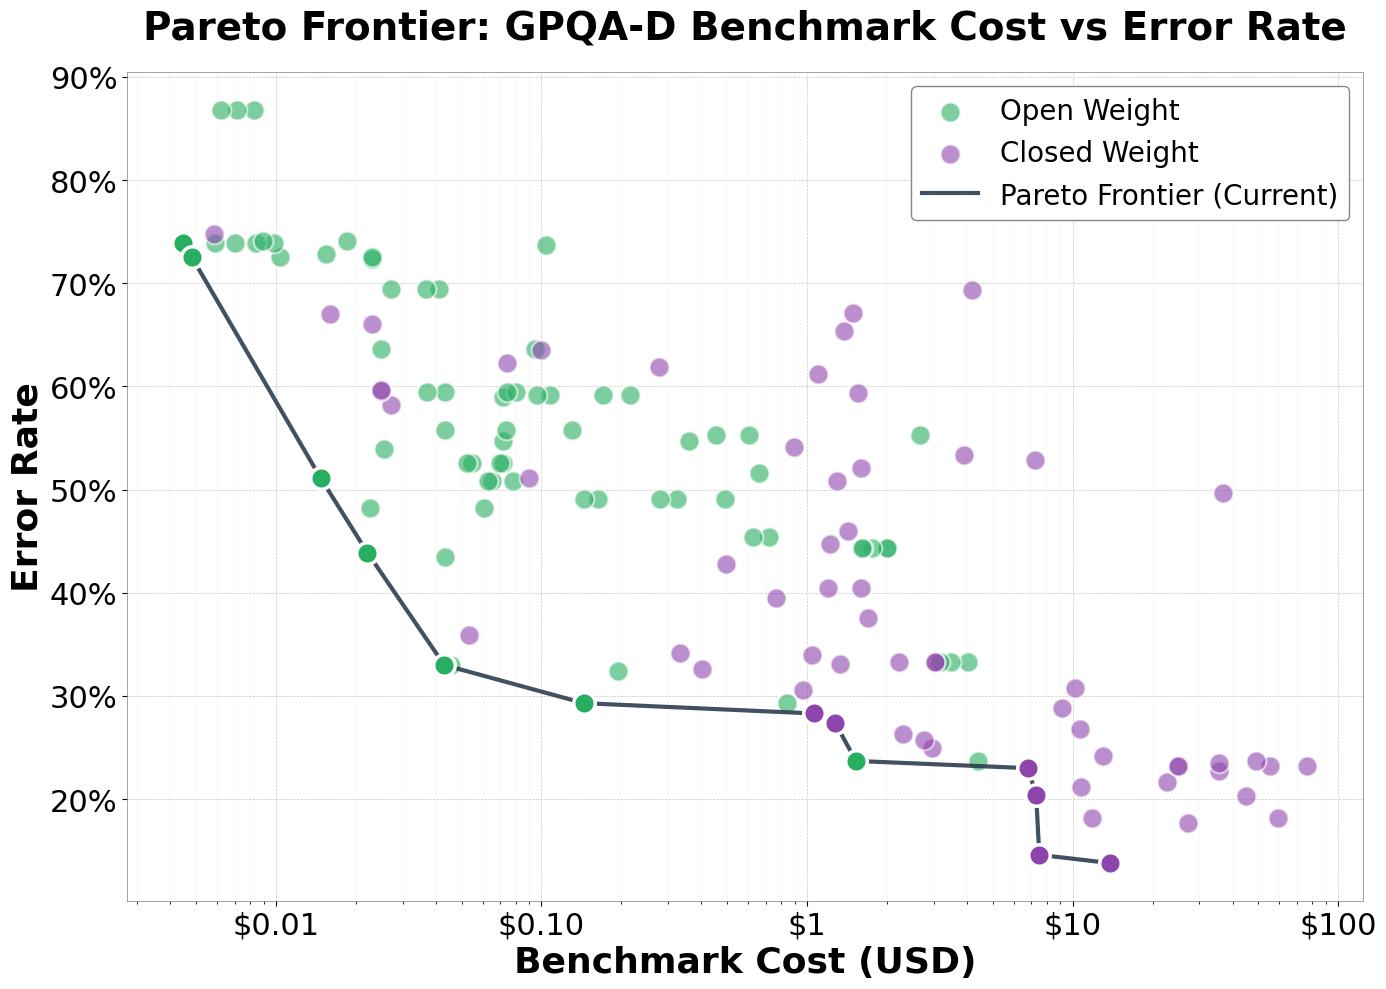

(<Figure size 1400x1000 with 1 Axes>,
 <Axes: title={'center': 'Pareto Frontier: GPQA-D Benchmark Cost vs Error Rate'}, xlabel='Benchmark Cost (USD)', ylabel='Error Rate'>)

In [74]:
# Pareto curve colored by open weight
plot_pareto_curves(
    df,
    price_col='Benchmark Cost USD',
    benchmark_col='epoch_gpqa',
    color_by='open_weight',
    show_model_names=False,
    time_periods=None,
    include_current=True,
    title='Pareto Frontier: GPQA-D Benchmark Cost vs Error Rate',
    save_path='figures/pareto_by_license.png'
)

## Example 3: With Model Names

Figure saved to: figures/pareto_with_names.png


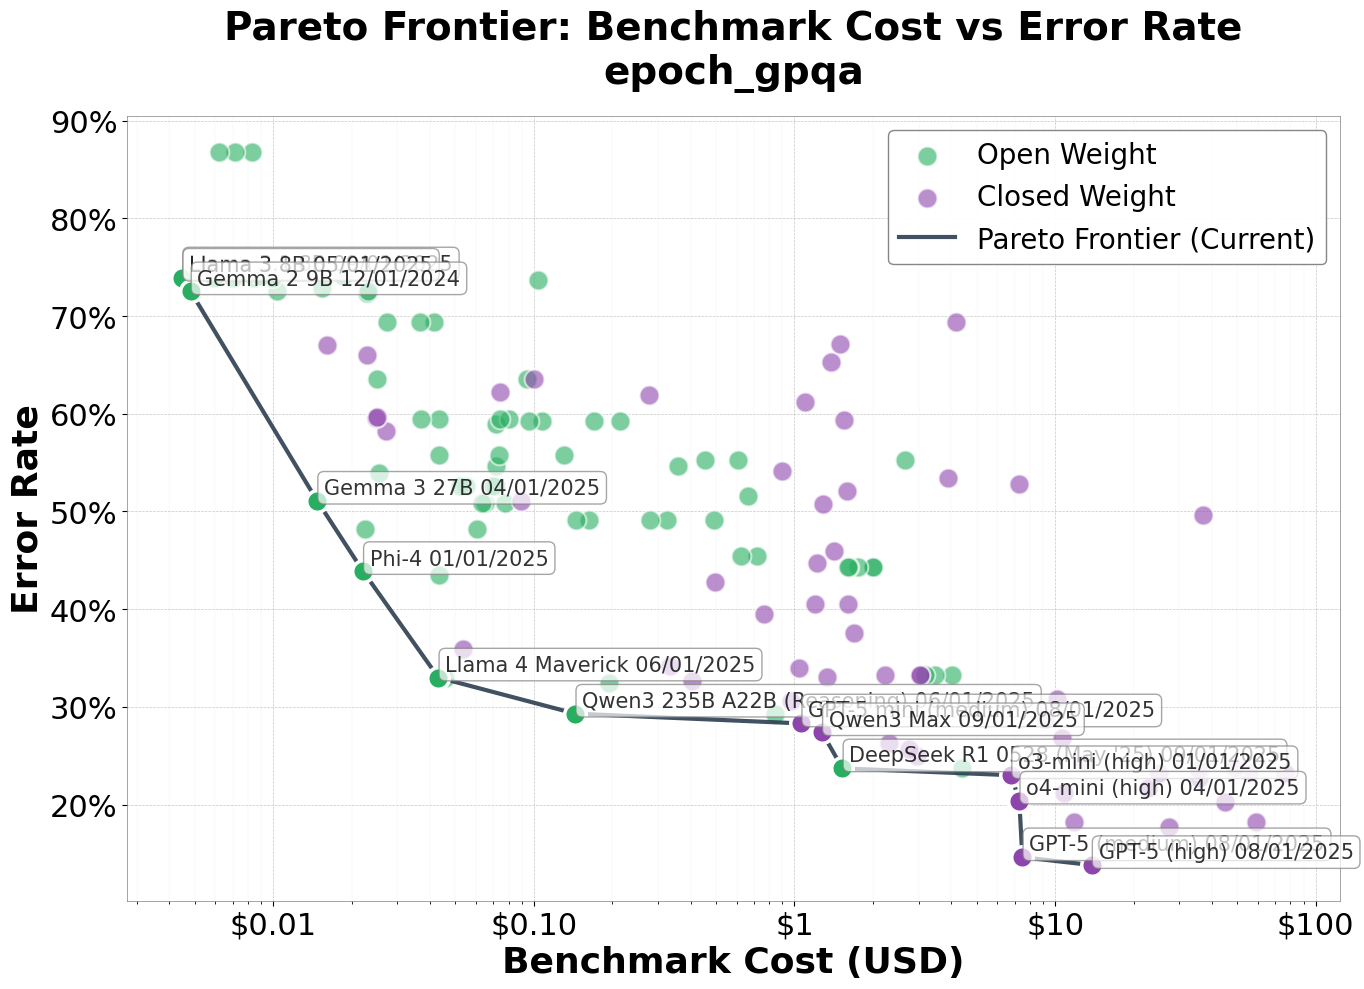

(<Figure size 1400x1000 with 1 Axes>,
 <Axes: title={'center': 'Pareto Frontier: Benchmark Cost vs Error Rate\nepoch_gpqa'}, xlabel='Benchmark Cost (USD)', ylabel='Error Rate'>)

In [75]:
# Pareto curve with model names displayed
plot_pareto_curves(
    df,
    price_col='Benchmark Cost USD',
    benchmark_col='epoch_gpqa',
    color_by='open_weight',
    show_model_names=True,
    time_periods=None,
    include_current=True,
    save_path='figures/pareto_with_names.png'
)

## Comparing Against OTIS-AIME

Model
Model Slug
Creator
License
Context
 Window
Access Date on AA
Artificial Analysis
 Intelligence Index
MMLU-Pro (Reasoning & Knowledge)
GPQA Diamond (Scientific Reasoning)
Humanity's Last Exam (Reasoning & Knowledge)
LiveCodeBench (Coding)
SciCode (Coding)
HumanEval (Coding)
MATH-500 (Quantitative Reasoning)
AIME 2024 (Competition Math)
Multilingual Index (Artificial Analysis)
Chatbot Arena
IFBench
LCR
Terminal-Bench Hard
___-Bench Telecom
Blended
 USD/1M Tokens
Median
 Tokens/s
P5
 Tokens/s
P25
 Tokens/s
P75
 Tokens/s
P95
 Tokens/s
Median
 First Chunk (s)
First Answer
 Token (s)
P5
 First Chunk (s)
P25
 First Chunk (s)
P75
 First Chunk (s)
P95
 First Chunk (s)
Total
 Response (s)
Reasoning
 Time (s)
Reasoning_TF
Further
 Analysis
Release Date
Parameters
Known Active Parameters
Latency
token/s
Chinese
Notes
Unnamed: 49
input_tokens_epoch_gpqa
output_tokens_epoch_gpqa
epoch_gpqa
gpqa_epochs
cache_read_gpqa
cache_output_gpqa
gpqa_reasoning_tokens
gpqa_reasoning_in_output
total_tokens

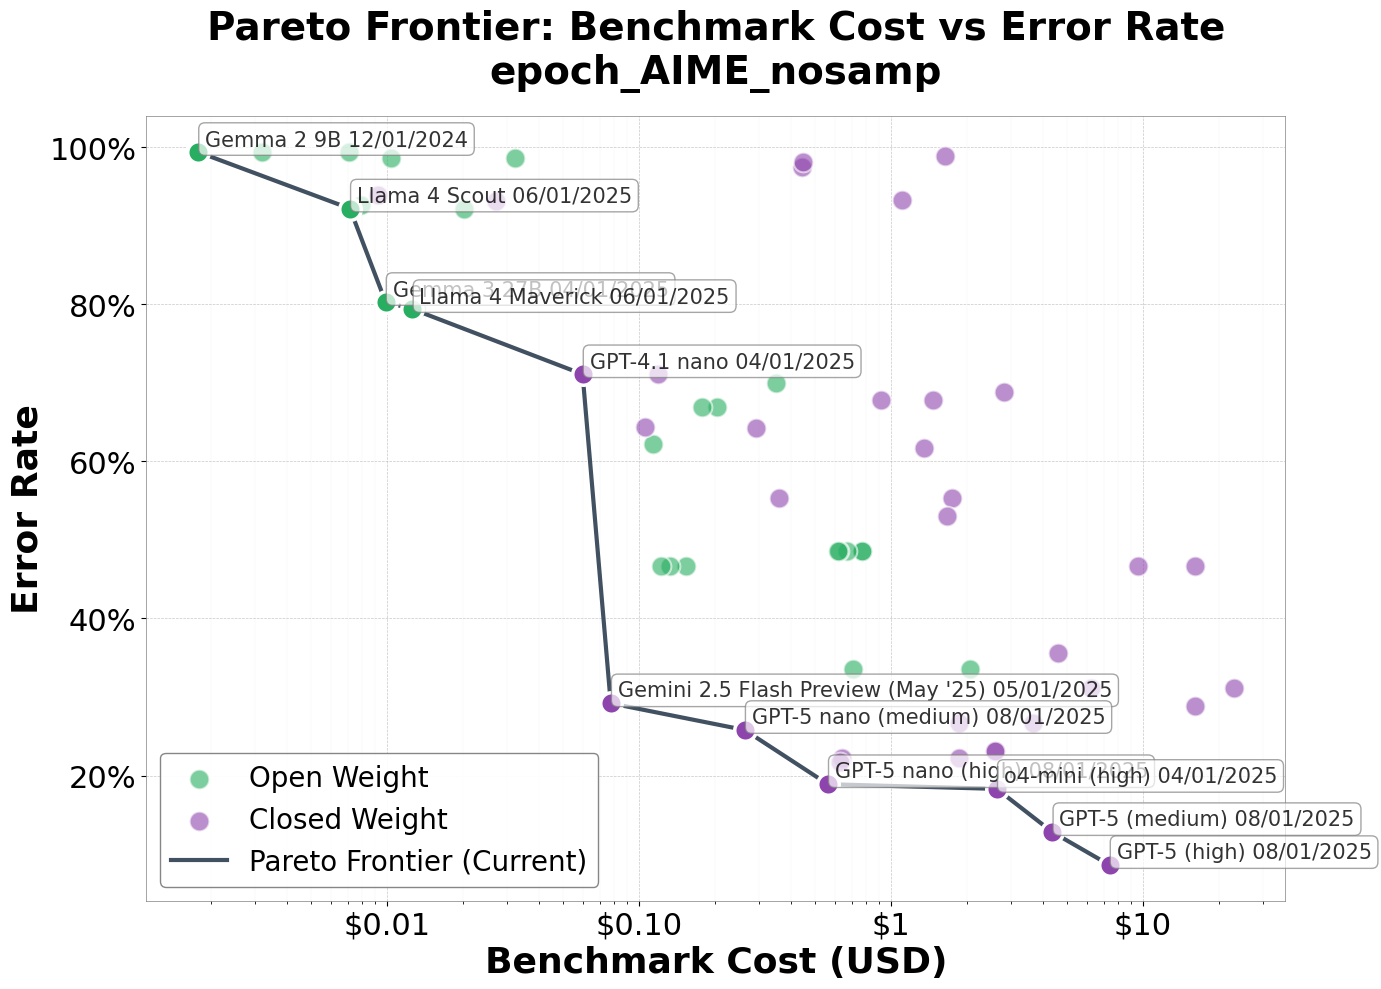

(<Figure size 1400x1000 with 1 Axes>,
 <Axes: title={'center': 'Pareto Frontier: Benchmark Cost vs Error Rate\nepoch_AIME_nosamp'}, xlabel='Benchmark Cost (USD)', ylabel='Error Rate'>)

In [76]:
# Pareto curve with model names displayed
df_aime = pd.read_csv('data/aime_price_reduction_models.csv')
for col in df_aime.columns:
    print(col)
print(f"Loaded {len(df_aime)} models")

# Load the main dataset
# Add MoE column: True if "Known Active Parameters" is not None, else False
df_aime["MoE"] = df_aime["Known Active Parameters"].notna()


print(df_aime['MoE'].to_string(index=True))

# Create a new DataFrame that only includes models where License is "Open"
df_open_aime = df_aime[df_aime["License"] == "Open"]
# print(f"Loaded {len(df_open)} open models")


print(f"Date range: {pd.to_datetime(df_aime['Release Date']).min()} to {pd.to_datetime(df_aime['Release Date']).max()}")
plot_pareto_curves(
    df_aime,
    price_col='Benchmark Cost USD',
    benchmark_col='epoch_AIME_nosamp',
    color_by='open_weight',
    show_model_names=True,
    time_periods=None,
    include_current=True,
    save_path='figures/pareto_with_names.png'
)

## Pareto Curves Across Time AIME

Figure saved to: figures/pareto_evolution.png


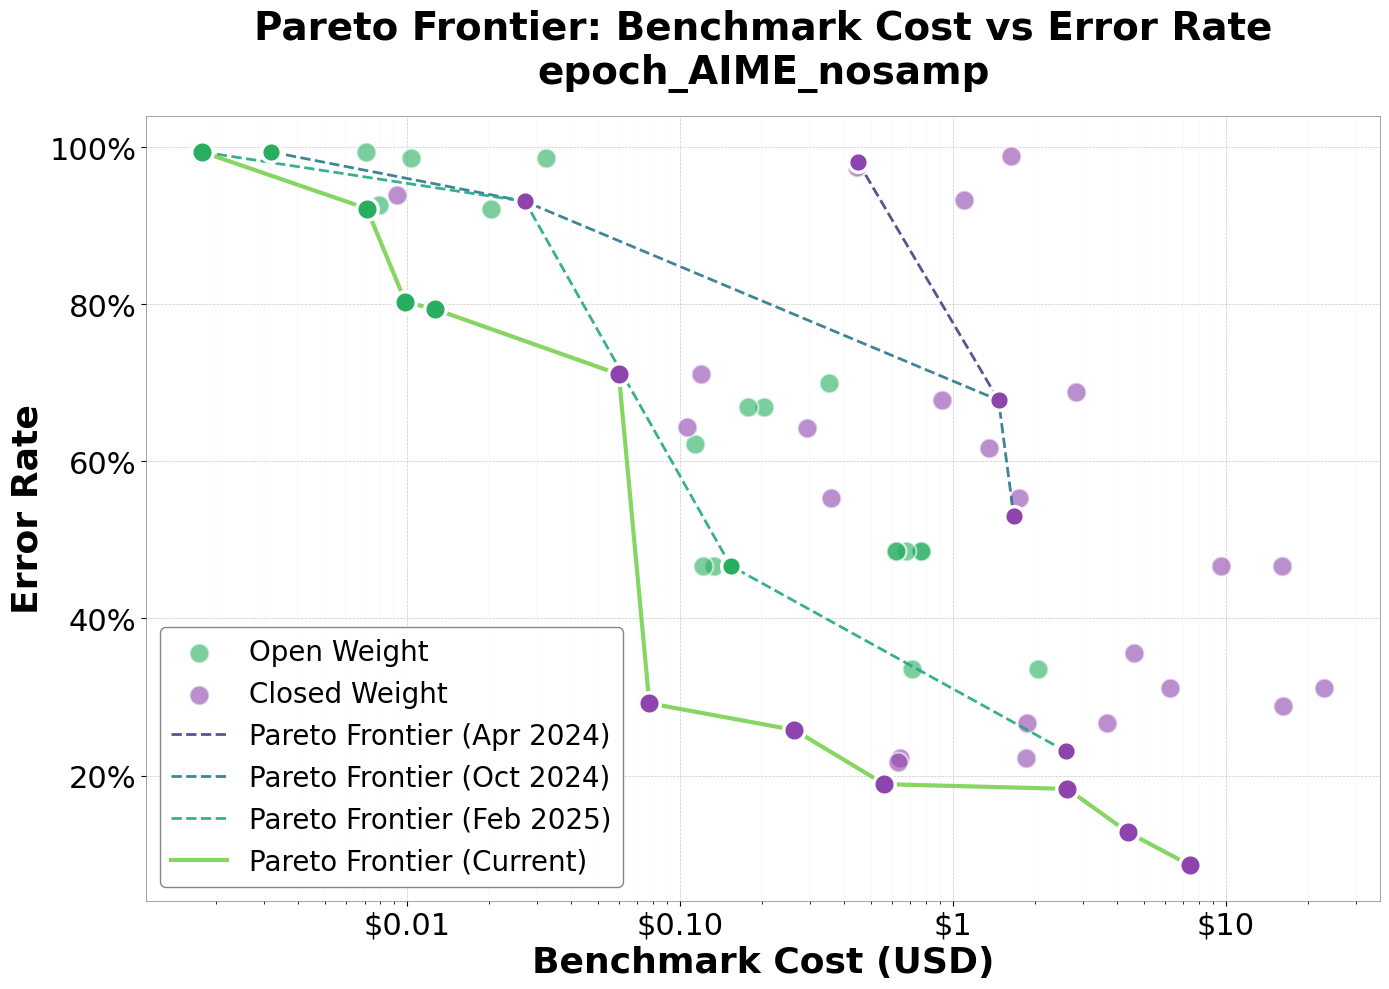

(<Figure size 1400x1000 with 1 Axes>,
 <Axes: title={'center': 'Pareto Frontier: Benchmark Cost vs Error Rate\nepoch_AIME_nosamp'}, xlabel='Benchmark Cost (USD)', ylabel='Error Rate'>)

In [77]:
plot_pareto_curves(
    df_aime,
    price_col='Benchmark Cost USD',
    benchmark_col='epoch_AIME_nosamp',
    color_by='open_weight',
    show_model_names=False,
    time_periods=[
        (4, 2024),   # April 2024
        (10, 2024),  # October 2024
        (2, 2025),
    ],
    include_current=True,
    save_path='figures/pareto_evolution.png'
)

## Example 4: Multiple Time Periods (Pareto Frontier Evolution)

Figure saved to: figures/pareto_evolution.png


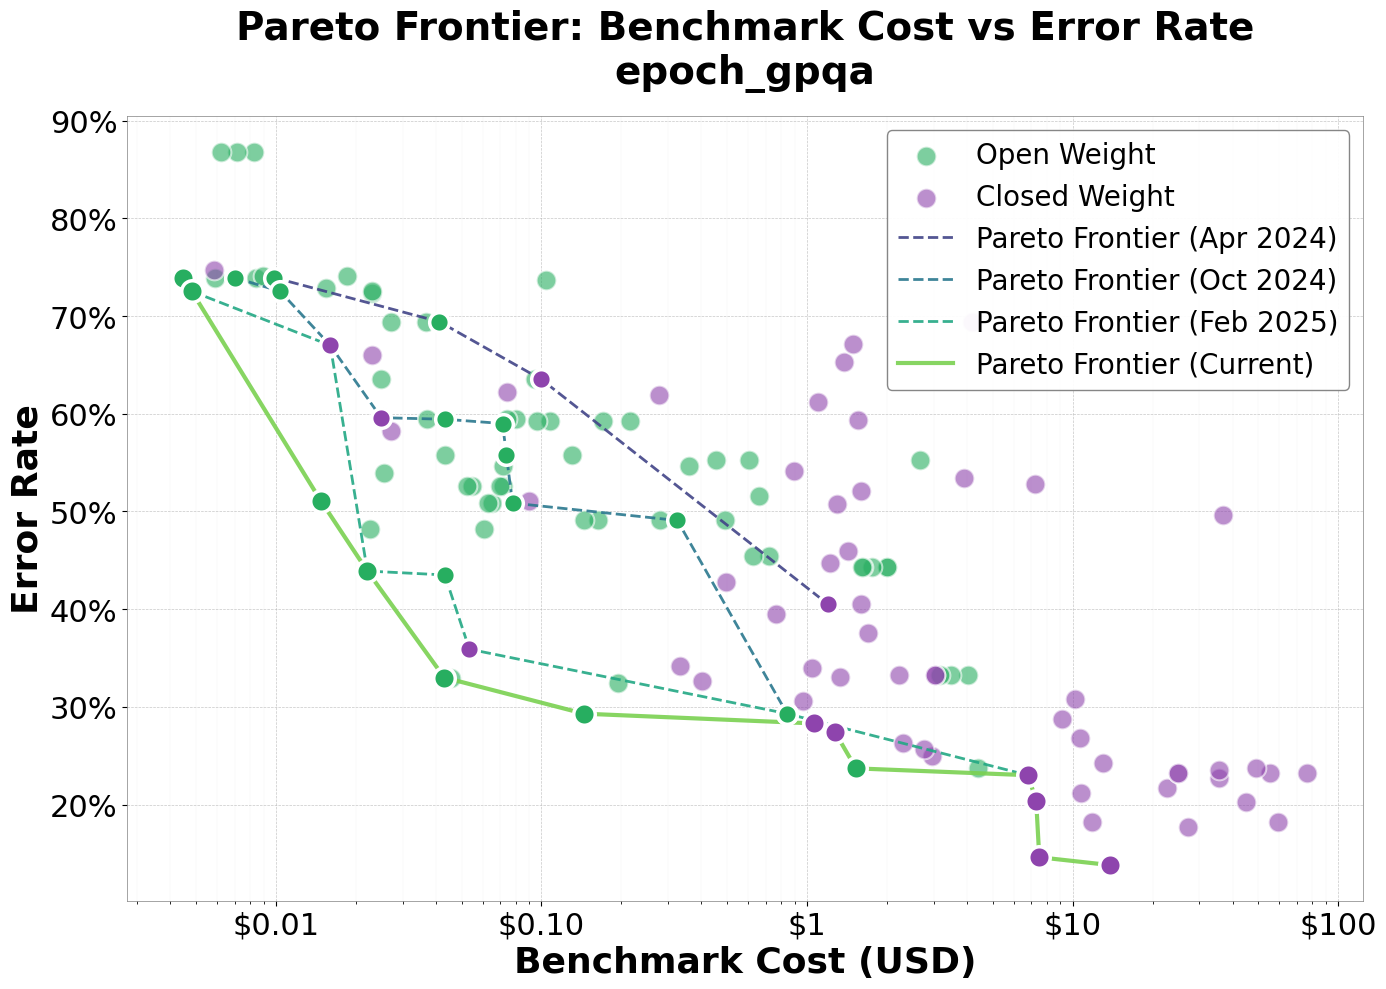

(<Figure size 1400x1000 with 1 Axes>,
 <Axes: title={'center': 'Pareto Frontier: Benchmark Cost vs Error Rate\nepoch_gpqa'}, xlabel='Benchmark Cost (USD)', ylabel='Error Rate'>)

In [78]:
# Pareto frontier evolution over time
# Shows how the frontier has shifted from Apr 2024 to current
plot_pareto_curves(
    df,
    price_col='Benchmark Cost USD',
    benchmark_col='epoch_gpqa',
    color_by='open_weight',
    show_model_names=False,
    time_periods=[
        (4, 2024),   # April 2024
        (10, 2024),  # October 2024
        (2, 2025),
    ],
    include_current=True,
    save_path='figures/pareto_evolution.png'
)

## Example 5: GPQA Diamond Benchmark

Figure saved to: figures/pareto_gpqa.png


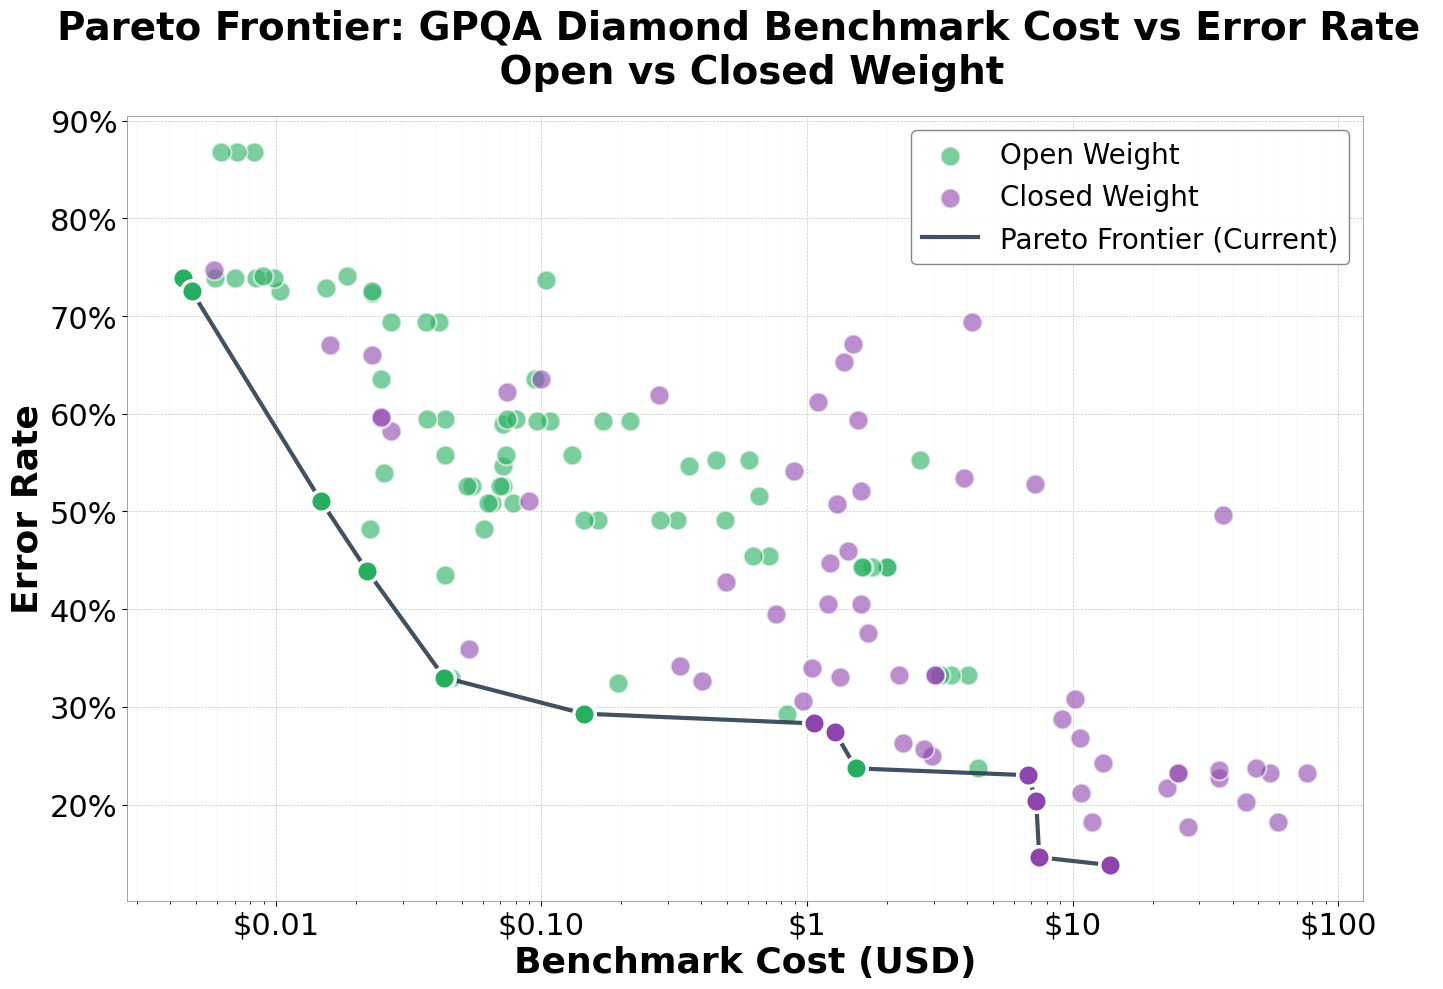

(<Figure size 1400x1000 with 1 Axes>,
 <Axes: title={'center': 'Pareto Frontier: GPQA Diamond Benchmark Cost vs Error Rate \n Open vs Closed Weight'}, xlabel='Benchmark Cost (USD)', ylabel='Error Rate'>)

In [79]:
# Pareto curve for GPQA Diamond benchmark
plot_pareto_curves(
    df,
    price_col='Benchmark Cost USD',
    benchmark_col='epoch_gpqa',
    color_by='open_weight',
    show_model_names=False,
    include_current=True,
    title='Pareto Frontier: GPQA Diamond Benchmark Cost vs Error Rate \n Open vs Closed Weight',
    save_path='figures/pareto_gpqa.png'
)

## Example 6: Open Weight Models Only

Figure saved to: figures/pareto_open_only.png


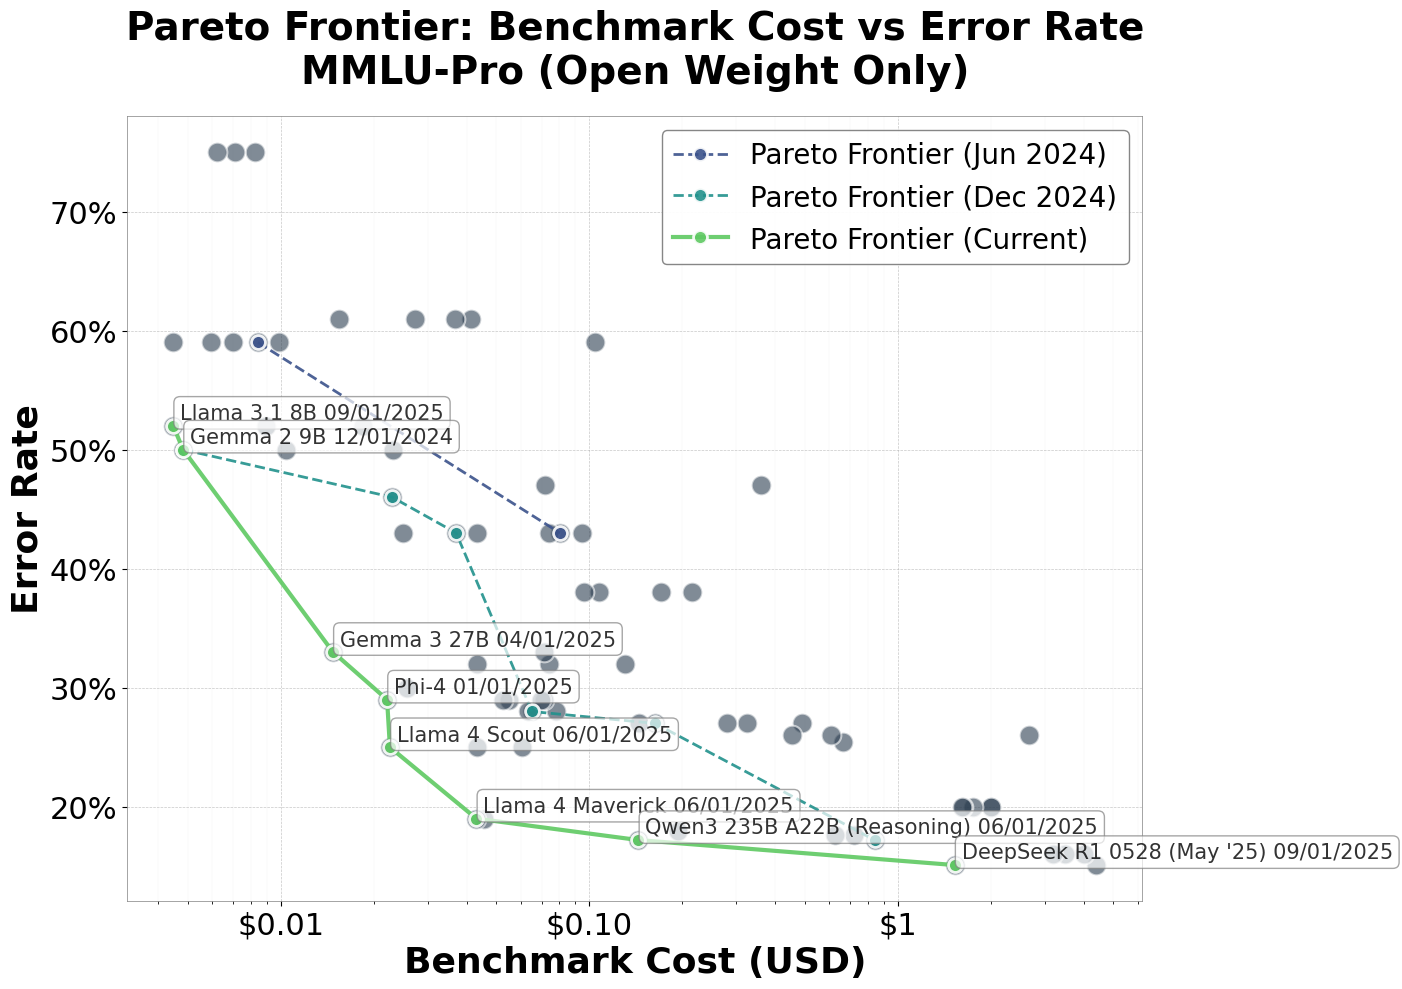

(<Figure size 1400x1000 with 1 Axes>,
 <Axes: title={'center': 'Pareto Frontier: Benchmark Cost vs Error Rate\nMMLU-Pro (Open Weight Only)'}, xlabel='Benchmark Cost (USD)', ylabel='Error Rate'>)

In [80]:
# Pareto curve for open weight models only
plot_pareto_curves(
    df,
    price_col='Benchmark Cost USD',
    benchmark_col='MMLU-Pro (Reasoning & Knowledge)',
    color_by=None,
    show_model_names=True,
    time_periods=[
        (6, 2024),
        (12, 2024),
    ],
    include_current=True,
    open_license_only=True,
    save_path='figures/pareto_open_only.png'
)

## Example 7: Color by MoE (if column exists)

If you have a column indicating whether a model is Mixture of Experts, you can use it like this:

Figure saved to: figures/pareto_by_moe.png


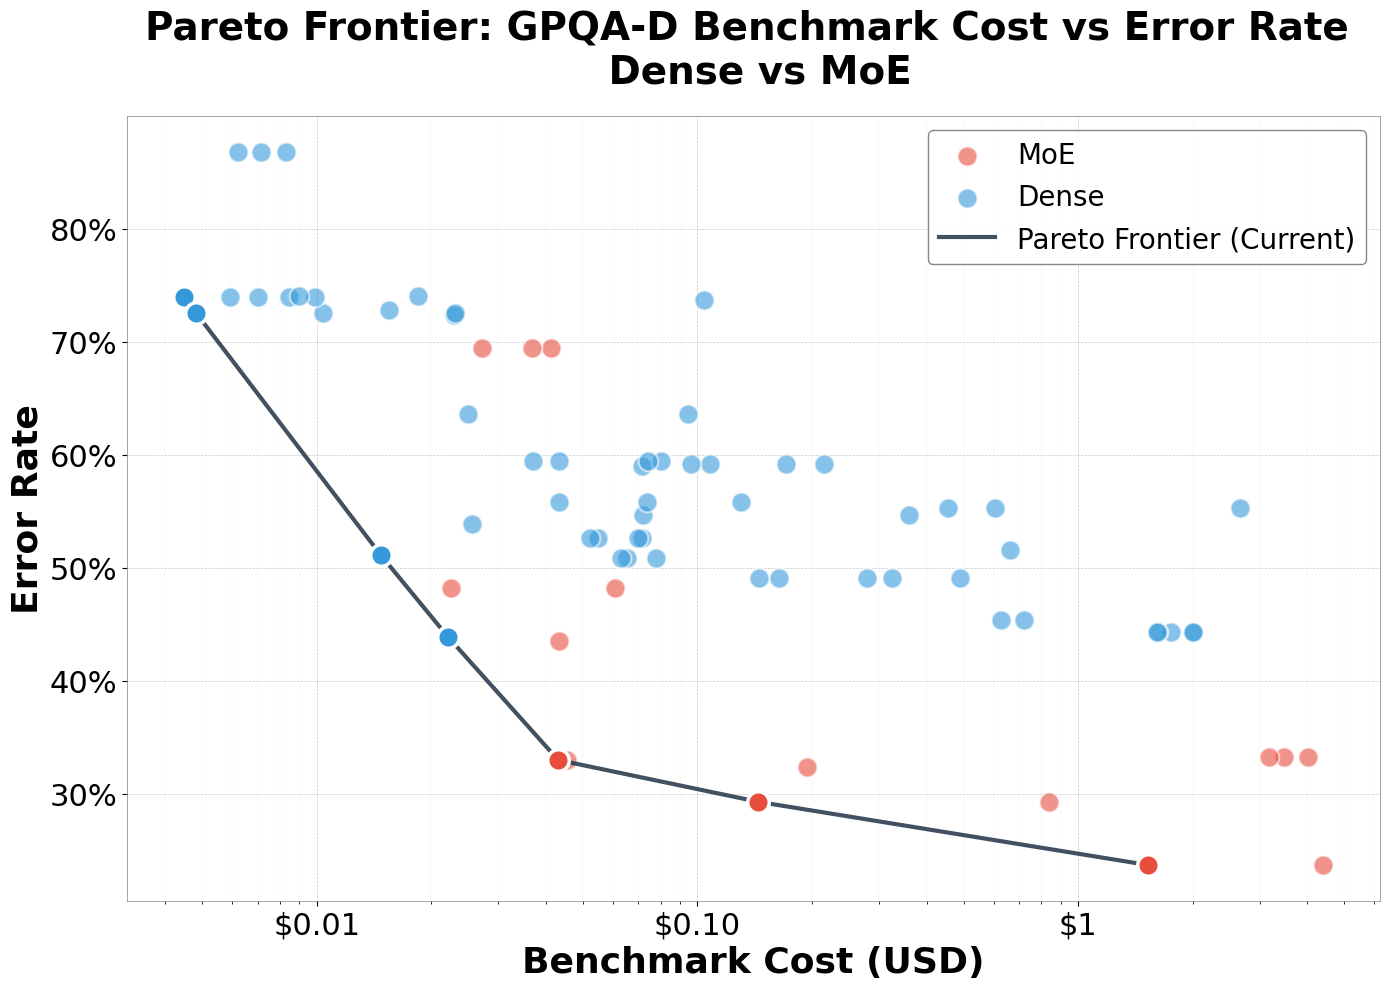

(<Figure size 1400x1000 with 1 Axes>,
 <Axes: title={'center': 'Pareto Frontier: GPQA-D Benchmark Cost vs Error Rate \n Dense vs MoE'}, xlabel='Benchmark Cost (USD)', ylabel='Error Rate'>)

In [81]:
# Example: If you have an 'is_moe' column in your data
# Uncomment and modify if you add this column to your dataset

plot_pareto_curves(
    df_open,
    price_col='Benchmark Cost USD',
    
    benchmark_col='epoch_gpqa',
    color_by='moe',  # Must be lowercase 'moe' to match function check
    moe_col='MoE',  # This is the column name in the dataframe (can be any case)
    show_model_names=False,
    # time_periods=[(6, 2024), (12, 2024)],
    include_current=True,
    title='Pareto Frontier: GPQA-D Benchmark Cost vs Error Rate \n Dense vs MoE',
    save_path='figures/pareto_by_moe.png'
)

Figure saved to: figures/pareto_by_moe.png


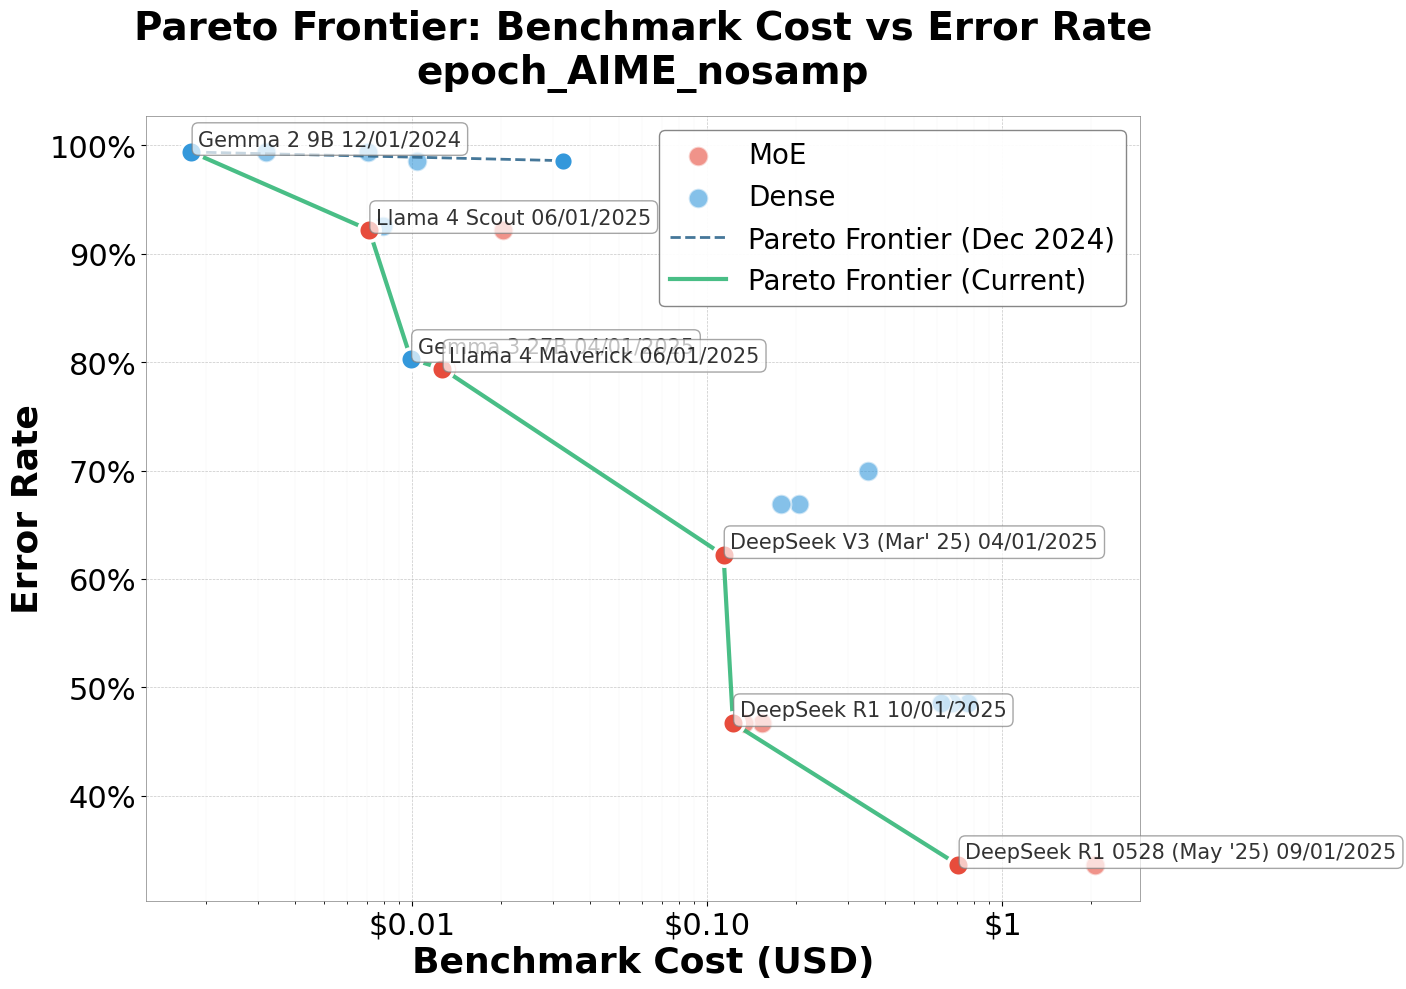

(<Figure size 1400x1000 with 1 Axes>,
 <Axes: title={'center': 'Pareto Frontier: Benchmark Cost vs Error Rate\nepoch_AIME_nosamp'}, xlabel='Benchmark Cost (USD)', ylabel='Error Rate'>)

In [82]:
# Example: If you have an 'is_moe' column in your data
# Uncomment and modify if you add this column to your dataset

plot_pareto_curves(
    df_open_aime,
    price_col='Benchmark Cost USD',
    benchmark_col='epoch_AIME_nosamp',
    color_by='moe',  # Must be lowercase 'moe' to match function check
    moe_col='MoE',  # This is the column name in the dataframe (can be any case)
    show_model_names=True,
    time_periods=[(6, 2024), (12, 2024)],
    include_current=True,
    save_path='figures/pareto_by_moe.png'
)

## Summary Statistics for Pareto Frontier

In [83]:
def get_pareto_stats(df, price_col='Benchmark Cost USD', benchmark_col='MMLU-Pro (Reasoning & Knowledge)'):
    """
    Calculate statistics for models on the Pareto frontier.
    """
    df_work = df.copy()
    
    # Parse benchmark scores
    df_work[benchmark_col] = (
        df_work[benchmark_col].astype(str)
        .str.replace('%', '', regex=False)
        .str.strip()
    )
    df_work[benchmark_col] = pd.to_numeric(df_work[benchmark_col], errors='coerce')
    df_work['error_rate'] = 1 - (df_work[benchmark_col] / 100)
    
    # Parse prices
    df_work[price_col] = (
        df_work[price_col].astype(str)
        .str.replace('[$,]', '', regex=True)
    )
    df_work[price_col] = pd.to_numeric(df_work[price_col], errors='coerce')
    
    # Drop missing data
    df_work = df_work.dropna(subset=[price_col, 'error_rate'])
    df_work = df_work[df_work[price_col] > 0]
    
    # Calculate Pareto frontier
    pareto_df = calculate_pareto_frontier(df_work, price_col, 'error_rate')
    
    print(f"\n=== Pareto Frontier Statistics ===")
    print(f"Total models: {len(df_work)}")
    print(f"Pareto optimal models: {len(pareto_df)}")
    print(f"Percentage on frontier: {len(pareto_df)/len(df_work)*100:.1f}%")
    print(f"\nPrice range: ${pareto_df[price_col].min():.3f} - ${pareto_df[price_col].max():.2f}")
    print(f"Error rate range: {pareto_df['error_rate'].min()*100:.2f}% - {pareto_df['error_rate'].max()*100:.2f}%")
    print(f"\nModels on Pareto frontier:")
    print(pareto_df[['Model', price_col, 'error_rate', 'License']].to_string(index=False))
    
    return pareto_df

# Example usage
pareto_models = get_pareto_stats(df)


=== Pareto Frontier Statistics ===
Total models: 128
Pareto optimal models: 12
Percentage on frontier: 9.4%

Price range: $0.004 - $49.21
Error rate range: 12.70% - 52.00%

Models on Pareto frontier:
                                       Model  Benchmark Cost USD  error_rate     License
                     Llama 3.1 8B 09/01/2025            0.004478       0.520        Open
                       Gemma 2 9B 12/01/2024            0.004822       0.500        Open
                      Gemma 3 27B 04/01/2025            0.014755       0.330        Open
                            Phi-4 01/01/2025            0.022102       0.290        Open
                    Llama 4 Scout 06/01/2025            0.022579       0.250        Open
                 Llama 4 Maverick 06/01/2025            0.043060       0.190        Open
      Qwen3 235B A22B (Reasoning) 06/01/2025            0.144335       0.172        Open
       DeepSeek R1 0528 (May '25) 09/01/2025            1.528776       0.151        Ope

## Separate Pareto Frontiers for MoE vs Dense Models

Create a plot showing two distinct Pareto frontiers: one for MoE models and one for Dense models.

In [88]:
def plot_separate_moe_dense_frontiers(
    df,
    price_col='Benchmark Cost USD',
    benchmark_col='epoch_gpqa',
    moe_col='MoE',
    show_model_names=False,
    open_license_only=False,
    extend_frontier=True,  # New parameter to extend frontier lines
    figsize=(14, 10),
    title=None,
    save_path=None
):
    """
    Plot separate Pareto frontiers for MoE and Dense models on the same graph.
    
    Parameters:
        df: DataFrame containing model data
        price_col: Column name for benchmark price (x-axis)
        benchmark_col: Column name for benchmark score (will be converted to error rate)
        moe_col: Column name for MoE indicator (True/False)
        show_model_names: If True, display model names for Pareto frontier points
        open_license_only: If True, only include open-weight models
        extend_frontier: If True, extend frontier lines to cover full axis space
        figsize: Figure size tuple (width, height)
        title: Custom title for the plot
        save_path: Optional path to save the figure
    
    Returns:
        fig, ax: matplotlib figure and axes objects
    """
    
    # Font size parameters
    TICK_LABELSIZE = 22
    AXIS_LABELSIZE = 26
    AXIS_LABELWEIGHT = 'bold'
    TITLE_FONTSIZE = 28
    TITLE_FONTWEIGHT = 'bold'
    TITLE_PAD = 24
    LEGEND_FONTSIZE = 20
    ANNOTATE_FONTSIZE = 15
    POINT_SIZE_SCATTER = 200
    PARETO_POINT_SIZE = int(1.2 * POINT_SIZE_SCATTER)
    
    # Work on a copy
    df_work = df.copy()
    
    # Parse benchmark scores
    df_work[benchmark_col] = (
        df_work[benchmark_col].astype(str)
        .str.replace('%', '', regex=False)
        .str.strip()
    )
    df_work[benchmark_col] = pd.to_numeric(df_work[benchmark_col], errors='coerce')
    df_work['error_rate'] = 1 - (df_work[benchmark_col] / 100)
    
    # Parse prices
    df_work[price_col] = (
        df_work[price_col].astype(str)
        .str.replace('[$,]', '', regex=True)
    )
    df_work[price_col] = pd.to_numeric(df_work[price_col], errors='coerce')
    
    # Parse dates
    df_work['Release Date'] = pd.to_datetime(df_work['Release Date'])
    
    # Filter: open license
    if open_license_only:
        df_work = df_work[
            df_work['License'].notna() &
            df_work['License'].str.contains('open', case=False, na=False)
        ]
    
    # Drop rows with missing data
    df_work = df_work.dropna(subset=['Release Date', price_col, 'error_rate', moe_col])
    df_work = df_work[df_work[price_col] > 0]
    
    if len(df_work) == 0:
        print("No valid data to plot after filtering")
        return None, None
    
    # Get axis limits from all data
    max_price = df_work[price_col].max()
    max_error = df_work['error_rate'].max()
    
    # Split data into MoE and Dense
    df_moe = df_work[df_work[moe_col] == True].copy()
    df_dense = df_work[df_work[moe_col] == False].copy()
    
    print(f"Total models: {len(df_work)}")
    print(f"MoE models: {len(df_moe)}")
    print(f"Dense models: {len(df_dense)}")
    
    # Set up the plot
    fig, ax = plt.subplots(figsize=figsize, dpi=100)
    fig.patch.set_facecolor('white')
    ax.set_facecolor('white')
    
    # Colors for MoE and Dense
    moe_color = '#E74C3C'  # Red
    dense_color = '#3498DB'  # Blue
    
    # Plot all points (scatter)
    if len(df_moe) > 0:
        ax.scatter(
            df_moe[price_col],
            df_moe['error_rate'],
            c=moe_color,
            s=POINT_SIZE_SCATTER,
            alpha=0.6,
            edgecolors='white',
            linewidth=1.5,
            label='MoE Models',
            zorder=3
        )
    
    if len(df_dense) > 0:
        ax.scatter(
            df_dense[price_col],
            df_dense['error_rate'],
            c=dense_color,
            s=POINT_SIZE_SCATTER,
            alpha=0.6,
            edgecolors='white',
            linewidth=1.5,
            label='Dense Models',
            zorder=3
        )
    
    # Calculate and plot MoE Pareto frontier
    if len(df_moe) > 0:
        pareto_moe = calculate_pareto_frontier(df_moe, price_col, 'error_rate')
        print(f"\nMoE Pareto frontier points: {len(pareto_moe)}")
        
        if len(pareto_moe) > 0:
            # Extend frontier if requested
            if extend_frontier:
                pareto_extended = pareto_moe.copy()
                
                # Add vertical extension (upward from leftmost point)
                leftmost_point = pareto_moe.iloc[0]
                if leftmost_point['error_rate'] < max_error:
                    vertical_point = pd.DataFrame([{
                        price_col: leftmost_point[price_col],
                        'error_rate': max_error,
                        'Model': ''
                    }])
                    pareto_extended = pd.concat([vertical_point, pareto_extended], ignore_index=True)
                
                # Add horizontal extension (rightward from rightmost point)
                rightmost_point = pareto_moe.iloc[-1]
                if rightmost_point[price_col] < max_price:
                    horizontal_point = pd.DataFrame([{
                        price_col: max_price * 1.5,  # Extend a bit beyond max
                        'error_rate': rightmost_point['error_rate'],
                        'Model': ''
                    }])
                    pareto_extended = pd.concat([pareto_extended, horizontal_point], ignore_index=True)
                
                pareto_plot = pareto_extended
            else:
                pareto_plot = pareto_moe
            
            ax.plot(
                pareto_plot[price_col],
                pareto_plot['error_rate'],
                color=moe_color,
                linestyle='-',
                linewidth=3,
                label='MoE Pareto Frontier',
                zorder=5,
                alpha=0.9
            )
            
            # Plot markers only for original Pareto points (not extensions)
            ax.scatter(
                pareto_moe[price_col],
                pareto_moe['error_rate'],
                c=moe_color,
                s=PARETO_POINT_SIZE,
                marker='o',
                edgecolors='white',
                linewidth=2.5,
                zorder=6,
                alpha=1.0
            )
            
            # Add model names if requested
            if show_model_names:
                for _, row in pareto_moe.iterrows():
                    ax.annotate(
                        row['Model'],
                        (row[price_col], row['error_rate']),
                        xytext=(5, 5),
                        textcoords='offset points',
                        fontsize=ANNOTATE_FONTSIZE,
                        alpha=0.8,
                        bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7, edgecolor=moe_color),
                        zorder=7
                    )
    
    # Calculate and plot Dense Pareto frontier
    if len(df_dense) > 0:
        pareto_dense = calculate_pareto_frontier(df_dense, price_col, 'error_rate')
        print(f"Dense Pareto frontier points: {len(pareto_dense)}")
        
        if len(pareto_dense) > 0:
            # Extend frontier if requested
            if extend_frontier:
                pareto_extended = pareto_dense.copy()
                
                # Add vertical extension (upward from leftmost point)
                leftmost_point = pareto_dense.iloc[0]
                if leftmost_point['error_rate'] < max_error:
                    vertical_point = pd.DataFrame([{
                        price_col: leftmost_point[price_col],
                        'error_rate': max_error,
                        'Model': ''
                    }])
                    pareto_extended = pd.concat([vertical_point, pareto_extended], ignore_index=True)
                
                # Add horizontal extension (rightward from rightmost point)
                rightmost_point = pareto_dense.iloc[-1]
                if rightmost_point[price_col] < max_price:
                    horizontal_point = pd.DataFrame([{
                        price_col: max_price * 1.5,  # Extend a bit beyond max
                        'error_rate': rightmost_point['error_rate'],
                        'Model': ''
                    }])
                    pareto_extended = pd.concat([pareto_extended, horizontal_point], ignore_index=True)
                
                pareto_plot = pareto_extended
            else:
                pareto_plot = pareto_dense
            
            ax.plot(
                pareto_plot[price_col],
                pareto_plot['error_rate'],
                color=dense_color,
                linestyle='-',
                linewidth=3,
                label='Dense Pareto Frontier',
                zorder=5,
                alpha=0.9
            )
            
            # Plot markers only for original Pareto points (not extensions)
            ax.scatter(
                pareto_dense[price_col],
                pareto_dense['error_rate'],
                c=dense_color,
                s=PARETO_POINT_SIZE,
                marker='o',
                edgecolors='white',
                linewidth=2.5,
                zorder=6,
                alpha=1.0
            )
            
            # Add model names if requested
            if show_model_names:
                for _, row in pareto_dense.iterrows():
                    ax.annotate(
                        row['Model'],
                        (row[price_col], row['error_rate']),
                        xytext=(5, 5),
                        textcoords='offset points',
                        fontsize=ANNOTATE_FONTSIZE,
                        alpha=0.8,
                        bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7, edgecolor=dense_color),
                        zorder=7
                    )
    
    # Set log scale for x-axis (price)
    ax.set_xscale('log')
    
    # Format axes
    from matplotlib.ticker import FuncFormatter, PercentFormatter
    
    def dollar_formatter(x, pos):
        if x >= 1:
            return f"${x:.0f}"
        elif x >= 0.01:
            return f"${x:.2f}"
        elif x >= 0.001:
            return f"${x:.3f}"
        else:
            return f"${x:.4f}"
    
    ax.xaxis.set_major_formatter(FuncFormatter(dollar_formatter))
    ax.yaxis.set_major_formatter(PercentFormatter(1.0))
    
    # Labels and title
    ax.set_xlabel('Benchmark Cost (USD)', fontsize=AXIS_LABELSIZE, fontweight=AXIS_LABELWEIGHT)
    ax.set_ylabel('Error Rate', fontsize=AXIS_LABELSIZE, fontweight=AXIS_LABELWEIGHT)
    
    if title is None:
        benchmark_name = benchmark_col.split(' ')[0]
        plot_title = f'Separate Pareto Frontiers: MoE vs Dense Models\n{benchmark_name} Benchmark'
        if open_license_only:
            plot_title += ' (Open Weight Only)'
    else:
        plot_title = title
    
    ax.set_title(plot_title, fontsize=TITLE_FONTSIZE, fontweight=TITLE_FONTWEIGHT, pad=TITLE_PAD)
    
    # Grid
    ax.grid(True, which='major', linestyle='--', linewidth=0.5, alpha=0.7, zorder=0)
    ax.grid(True, which='minor', linestyle=':', linewidth=0.3, alpha=0.4, zorder=0)
    
    # Legend
    ax.legend(
        loc='best',
        fontsize=LEGEND_FONTSIZE,
        frameon=True,
        fancybox=True,
        framealpha=0.95,
        edgecolor='gray'
    )
    
    ax.tick_params(axis='both', which='major', labelsize=TICK_LABELSIZE)
    
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_color('gray')
        spine.set_linewidth(0.5)
    
    plt.tight_layout()
    
    # Save figure if requested
    if save_path is not None:
        import os
        output_dir = os.path.dirname(save_path)
        if output_dir and not os.path.exists(output_dir):
            os.makedirs(output_dir, exist_ok=True)
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"\nFigure saved to: {save_path}")
    
    plt.show()
    
    return fig, ax

Total models: 75
MoE models: 16
Dense models: 59

MoE Pareto frontier points: 4
Dense Pareto frontier points: 5

Figure saved to: figures/pareto_moe_vs_dense_gpqa.png


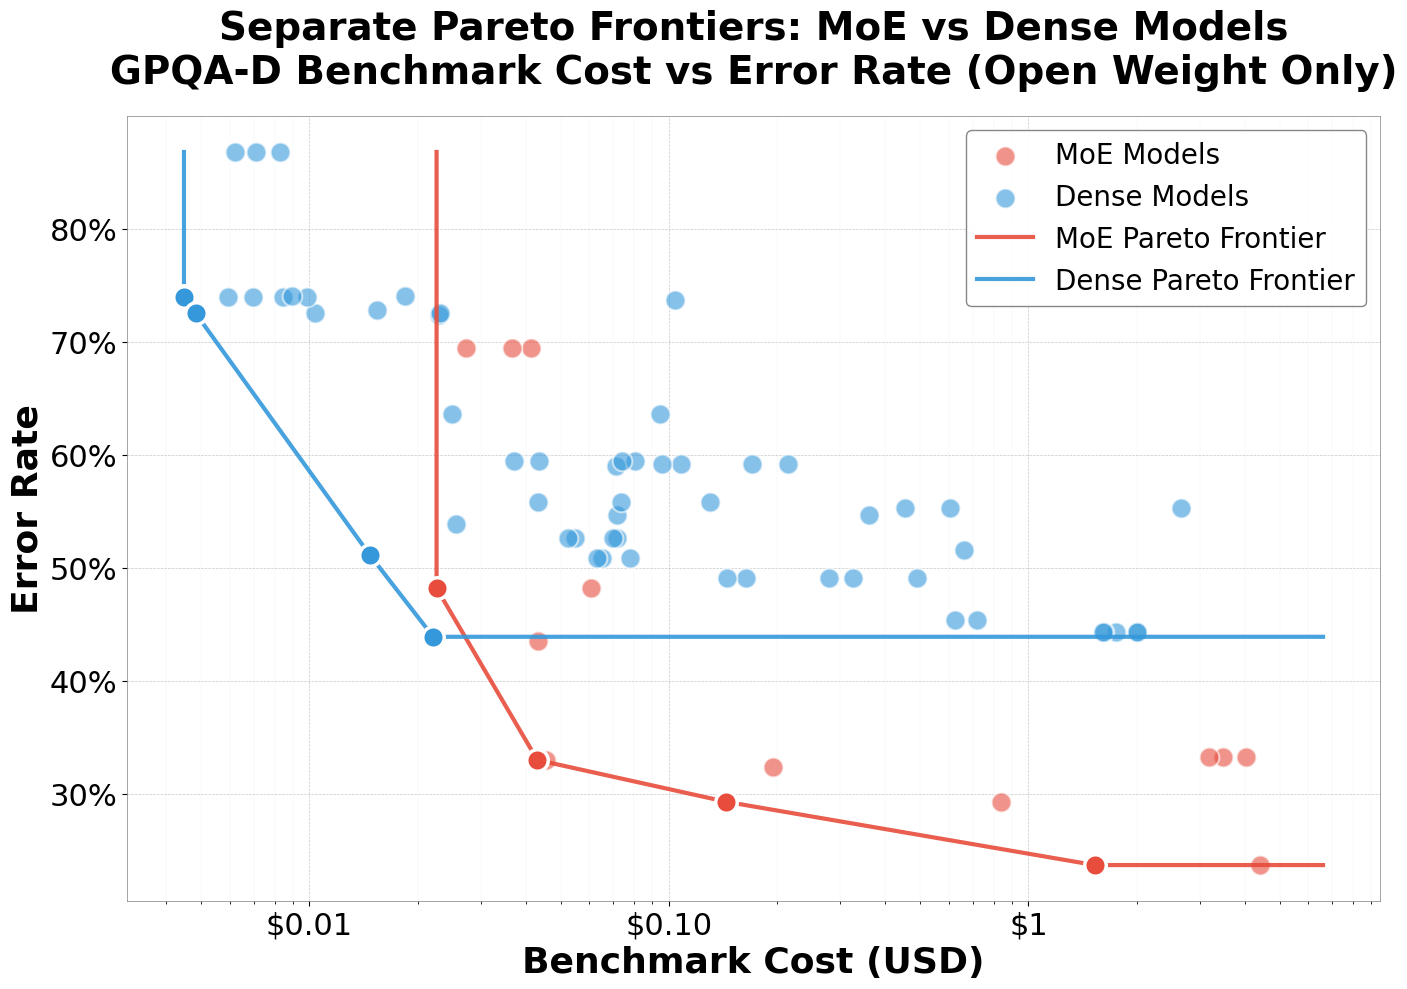

(<Figure size 1400x1000 with 1 Axes>,
 <Axes: title={'center': 'Separate Pareto Frontiers: MoE vs Dense Models\nGPQA-D Benchmark Cost vs Error Rate (Open Weight Only)'}, xlabel='Benchmark Cost (USD)', ylabel='Error Rate'>)

In [91]:
# Plot separate Pareto frontiers for MoE vs Dense models - GPQA-D
# Open-weight models only with extended frontier lines
plot_separate_moe_dense_frontiers(
    df,
    price_col='Benchmark Cost USD',
    benchmark_col='epoch_gpqa',
    moe_col='MoE',
    show_model_names=False,
    open_license_only=True,  # Only include open-weight models
    extend_frontier=True,  # Extend frontier lines to cover full axis space
    title='Separate Pareto Frontiers: MoE vs Dense Models\nGPQA-D Benchmark Cost vs Error Rate (Open Weight Only)',
    save_path='figures/pareto_moe_vs_dense_gpqa.png',
    
)